# Fixed Arc Length

The other notebooks will calculate the arc length of the spiral based on the cone width and height. This notebook will work on altering those parameters to fit a given arc length. Why do this? Well, the main use case is to fit a design to a specific length of LED strip. For example, how big of a cone can you build using a 5m strip without cutting or adding pieces to it.


# Notebook Preamble

In [1]:
%%javascript
//Disable autoscroll in the output cells - needs to be in a separate cell with nothing else
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
# decide whether charts will be displayed interactively or in a format that exports to pdf

# Interactive -----------------
# For interactive notebook uncomment:
%matplotlib notebook

# PDF -----------------
# For pdf plotting uncomment:
# %matplotlib inline
# import warnings
# warnings.filterwarnings('ignore')

%config InlineBackend.figure_formats = ['png', 'pdf'] #['svg']

#------------
# Setup matplotlib
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D # handle 3D plots
import matplotlib as mpl

# uncomment the following if you have more then 40 plots
# mpl.rcParams['figure.max_open_warning'] = 60

mpl.rc('font',family='monospace') # all font on the plot will be monospace

In [3]:
import numpy as np
from scipy import optimize

from plots import create_standard_figure, axis_legend_remove_duplicates
from common import (
    plot_cone, 
    plot_spiral, 
    plot_center_pole, 
    calculate_support_points, 
    spiral_arc_length_range, 
    plot_cone_and_sprial,
)

----

<IPython.core.display.Javascript object>


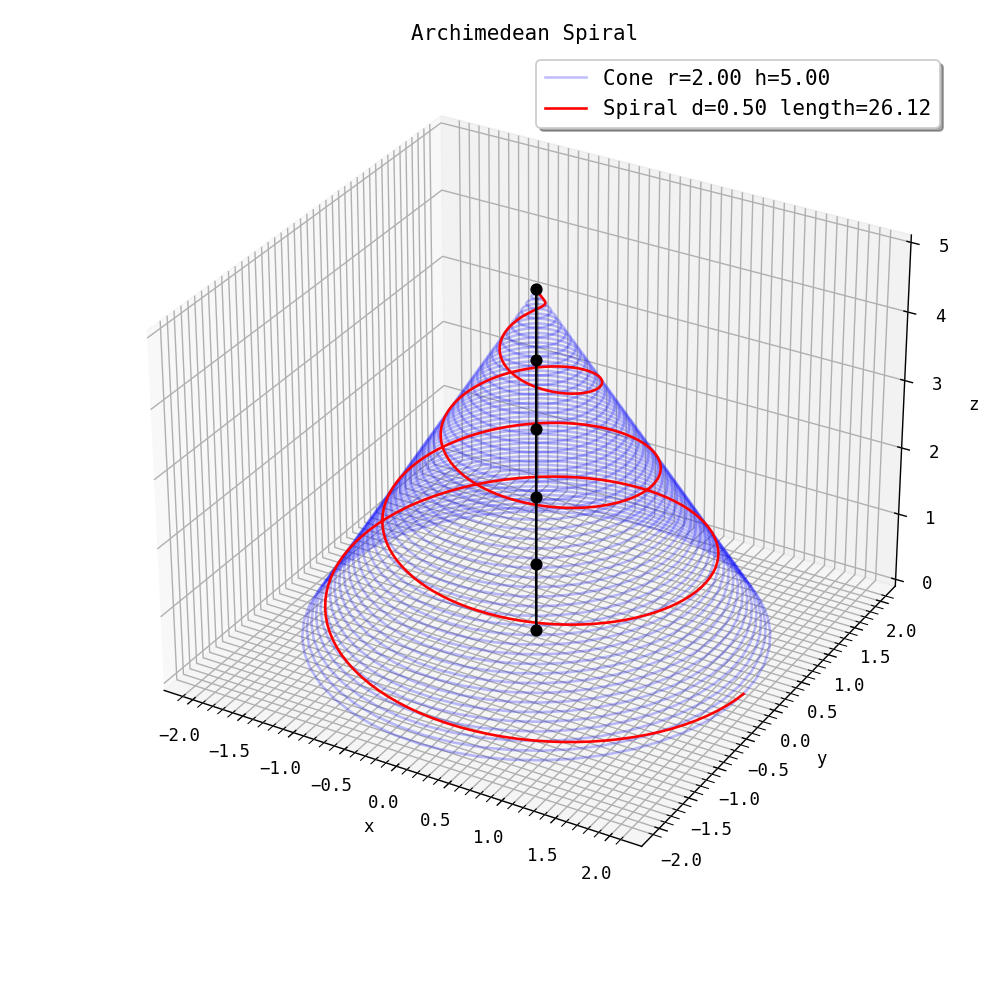

Cone Radius (r) = 2.0000
Cone Height (h) = 5.0000
Sprial Distance (d) = 0.5000


In [4]:
fig, ax = create_standard_figure(
    'Archimedean Spiral',
    'x',
    'y',
    'z',
    projection='3d',
    figsize=(8, 8),                                                  
    axes_rect=(0.1, 0.1, 0.85, 0.85), # rect [left, bottom, width, height]
) 

# NOTE: Units are in what every system you want as long as all length units are the same (ft, m, inches, mm)

# Cone
r = 2 # m
h = 5 # m
d = 0.5 # m

# d is the spacing between successive loops projected to the XY plane. 
# You can play with it to adjust the vertical spacing (XZ plane).

plot_cone_and_sprial(ax, r,h,d)

# ax.view_init(elev=0, azim=45)

fig.show() 

# Find the Arc Length

We want to determine the cone radius, height and loop spacing with a fixed spiral arc length. For example, we have a 5m strip and we do not want to cut it, what are the values of radius, height and loop spacing that will give us this fixed length. We'll use the [Scipy.Optimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) modules to determine this.

Let's construct a target function, below, formulated in a way that is compatible with te optimize module.

In [5]:
def objective_fixed_length(x, L:float):
    """
    This method defines the objective function, the function we want to minimize.
    This particular instance will search for r, h and d that generates a particular arc length, L.
    
    # args
    
    x - 1-D array with shape (n,) of variables to solve for
        - x[0] - r - cone base radius
        - x[1] - h - cone height
        - x[2] - d - horizontal spacing between loops
    
    L - The arc length we are attempting to find.
    
    # NOTE
    
    From the Scipy.Optimization docs: 
    
    The objective function to be minimized.

    fun(x, *args) -> float

    where x is an 1-D array with shape (n,) and args is a tuple of the 
    fixed parameters needed to completely specify the function.
    
    We have to construct the target function using this method to accomodate the optimize module
    It uses an array to specify the target variables that we want to optimize and separate arguments
    for the constants we don't want to optimize.
    
    """
    
#     r, h, d = x    
#     return np.abs(L - spiral_arc_length_range(r, h, d))

    return np.abs(L - spiral_arc_length_range(*x))

Let's use the minimize method and see what we can do.

<div class="alert alert-block alert-info"> <b>NOTE</b> We have to provide an initial guess for the other variables. The initial guess will affect the outcome. Most likely there are many solutions to the problem. It is recommended to use values close to the dimensions you are interested in. </div>

In [6]:
arc_length = 5   # m
r_init = 1   # m
h_init = 3   # m
d_init = 0.5 # m

result = optimize.minimize(
    objective_fixed_length, 
    (r_init, h_init, d_init), 
    args=(arc_length,), 
    method='Nelder-Mead', 
    tol=1e-8,
)

print(result)
print('-------')

print('Optimal Values:')
print(f'r = {result.x[0]:.4f}')
print(f'h = {result.x[1]:.4f}')
print(f'd = {result.x[2]:.4f}')


 final_simplex: (array([[0.79863094, 3.15843977, 0.57331696],
       [0.79863094, 3.15843976, 0.57331696],
       [0.79863094, 3.15843976, 0.57331696],
       [0.79863094, 3.15843977, 0.57331696]]), array([1.97077732e-09, 3.20198268e-09, 3.69157505e-09, 5.59641045e-09]))
           fun: 1.9707773191157685e-09
       message: 'Optimization terminated successfully.'
          nfev: 165
           nit: 83
        status: 0
       success: True
             x: array([0.79863094, 3.15843977, 0.57331696])
-------
Optimal Values:
r = 0.7986
h = 3.1584
d = 0.5733


Let's construct a method that can do the optimization and plot the results, `plot_optimal`:

In [7]:
def find_optimal(func, arc_length, r_init, h_init, d_init):    
    """
    
    # args
    
    ax - matplotlib axis 
    func - target function for optimization
    arc_length - the arc length we are interested in finding
    r_init - the initial guess for radius
    h_init - the initial guess for height
    d_init - the initial guess for loop horizontal spacing
    
    # Return 
    
    A tuple containing the optimal radius, height and loop spacing (r, h, d) 
    for the given arc length
    
    """
    
    result = optimize.minimize(
        func, 
        (r_init, h_init, d_init), 
        args=(arc_length,), 
        method='Nelder-Mead', 
        tol=1e-8,
    )
    
    return result.x

The code below demonstrates how to use the above function:

<IPython.core.display.Javascript object>


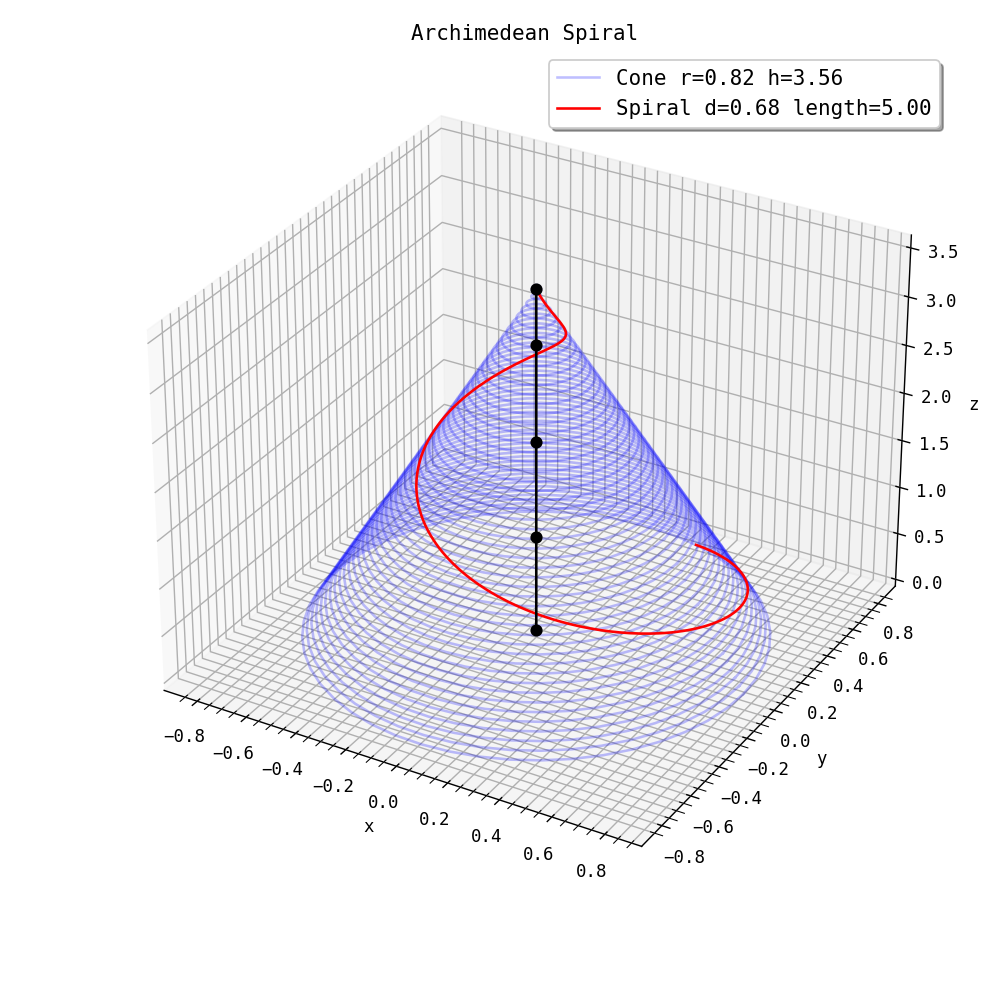

Cone Radius (r) = 0.8185
Cone Height (h) = 3.5565
Sprial Distance (d) = 0.6771


In [8]:
fig, ax = create_standard_figure(
    'Archimedean Spiral',
    'x',
    'y',
    'z',
    projection='3d',
    figsize=(8, 8),                                                  
    axes_rect=(0.1, 0.1, 0.85, 0.85), # rect [left, bottom, width, height]
) 


arc_length = 5   # m
r_init = 2   # m
h_init = 3   # m
d_init = 0.5 # m

results = find_optimal(objective_fixed_length, arc_length, r_init, h_init, d_init)

plot_cone_and_sprial(ax, *results)

fig.show() 

From the above output, we can see that attempting to optimize for all variables at once leads to a lot of sub-optimal solutions. It might be better to simply hold more variables constant and vary only one at a time.

# Optimal Cone - Fix Loop Spacing - Vary Radius and Height

Given that there are many solutions when we are able to vary the radius, height and loop width at the same time. What happens if we constrain the methods to only solve for radius and height? We'll need to construct a new target function and a new optimal search routine.


In [9]:
# We have to construct the target function using this method to accomodate the optimize module
# It uses an array to specify the target variables that we want to optimize and separate arguments
# for the constants we don't want to optimize.
def target_function_rh(x, L, d):
    """
    This method defines the objective function, the function we want to minimize.
    This particular instance will search for r, h that generates a particular 
    arc length, L with loop spacing, d.
    
    # args
    
    x - 1-D array with shape (n,) of variables to solve for
        - x[0] - r - cone base radius
        - x[1] - h - cone height        
    
    L - The arc length we are attempting to find.
    d - The horizontal loop spacing we are interested in.
    
    # NOTE
    
    From the Scipy.Optimization docs: 
    
    The objective function to be minimized.

    fun(x, *args) -> float

    where x is an 1-D array with shape (n,) and args is a tuple of the 
    fixed parameters needed to completely specify the function.
    """
    
#     r, h, d = x    
#     return np.abs(L - spiral_arc_length_range(r, h, d))

    return np.abs(L - spiral_arc_length_range(*x, d))

In [10]:
def find_optimal_rh(func, arc_length, d, r_init, h_init):    
    """
    
    # args
    
    ax - matplotlib axis 
    func - target function for optimization
    arc_length - the arc length we are interested in finding
    d - the initial guess for loop horizontal spacing
    r_init - the initial guess for radius
    h_init - the initial guess for height
        
    # Return 
    
    A tuple containing the optimal radius, height and loop spacing (r, h, d) 
    for the given arc length
    
    """
    
    result = optimize.minimize(
        func, 
        (r_init, h_init), 
        args=(arc_length, d), 
        method='Nelder-Mead', 
        tol=1e-8,
    )
    
    return result.x

<IPython.core.display.Javascript object>


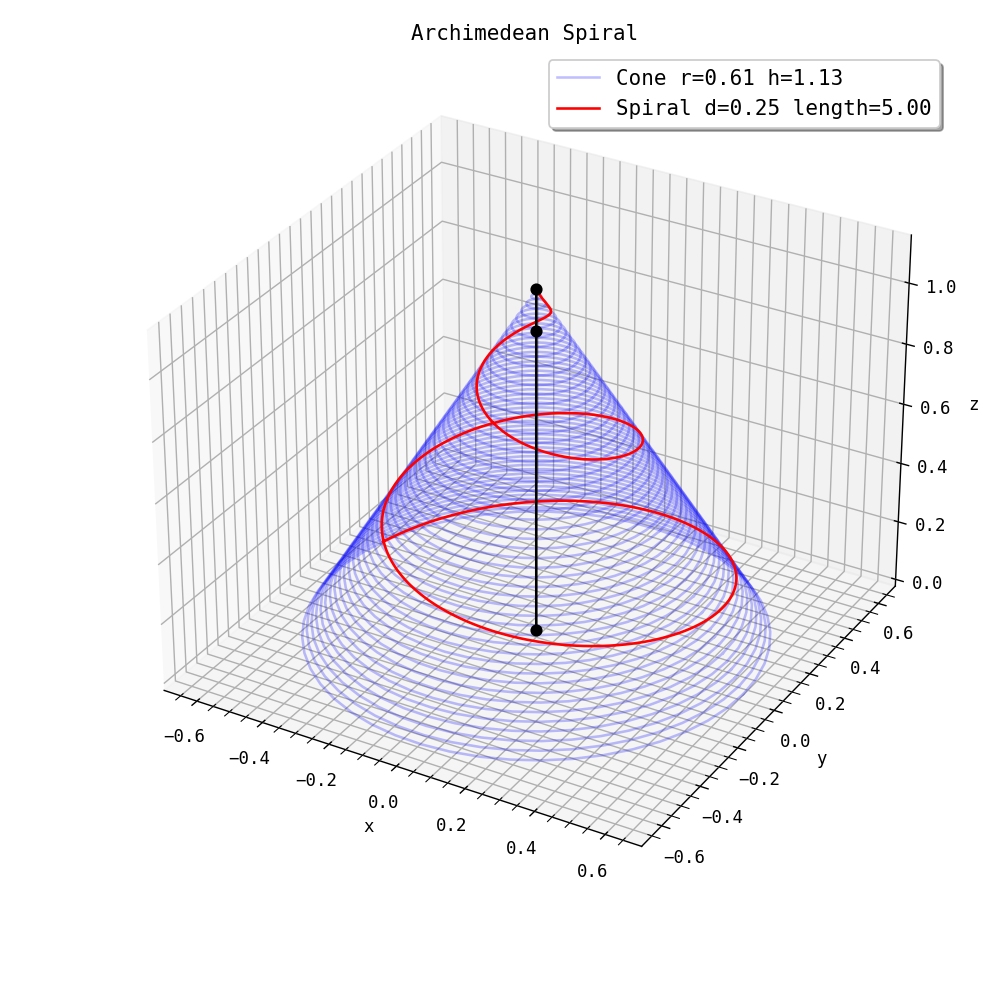

Cone Radius (r) = 0.6129
Cone Height (h) = 1.1321
Sprial Distance (d) = 0.2500


In [11]:
fig, ax = create_standard_figure(
    'Archimedean Spiral',
    'x',
    'y',
    'z',
    projection='3d',
    figsize=(8, 8),                                                  
    axes_rect=(0.1, 0.1, 0.85, 0.85), # rect [left, bottom, width, height]
) 


arc_length = 5   # m
d = 0.25 # m

r_init = 1   # m
h_init = 1   # m

results = find_optimal_rh(target_function_rh, arc_length, d, r_init, h_init)

plot_cone_and_sprial(ax, *results, d)

fig.show() 

By fixing the arc length and the d value we can achieve better designs with less trial and error.

# Optimal Cone - Fix Loop Spacing and Radius - Vary Height


In this case, will keep the radius fixed and the loop spacing fixed and we'll simple vary the height.


In [12]:
# We have to construct the target function using this method to accomodate the optimize module
# It uses an array to specify the target variables that we want to optimize and separate arguments
# for the constants we don't want to optimize.
def target_function_h(x, L, r, d):
    """
    This method defines the objective function, the function we want to minimize.
    This particular instance will search for h that generates a particular 
    arc length, L with loop spacing, d.
    
    # args
    
    x - 1-D array with shape (n,) of variables to solve for
        - x[0] - h - cone height        
    
    L - The arc length we are attempting to find.
    r - The radius of the base of the cone
    d - The horizontal loop spacing we are interested in.
    
    # NOTE
    
    From the Scipy.Optimization docs: 
    
    The objective function to be minimized.

    fun(x, *args) -> float

    where x is an 1-D array with shape (n,) and args is a tuple of the 
    fixed parameters needed to completely specify the function.
    """
    
#     r, h, d = x    
#     return np.abs(L - spiral_arc_length_range(r, h, d))

    return np.abs(L - spiral_arc_length_range(r, *x, d))

In [13]:
def find_optimal_h(func, arc_length, d, r, h_init):    
    """
    
    # args
    
    ax - matplotlib axis 
    func - target function for optimization
    arc_length - the arc length we are interested in finding
    d - the initial guess for loop horizontal spacing
    r - the initial guess for radius
    h_init - the initial guess for height
    
    
    # Return 
    
    A tuple containing the optimal radius, height and loop spacing (r, h, d) 
    for the given arc length
    
    """
    
    result = optimize.minimize(
        func, 
        (h_init, ), 
        args=(arc_length, r, d), 
        method='Nelder-Mead', 
        tol=1e-8,
    )
    
    return result.x

<IPython.core.display.Javascript object>


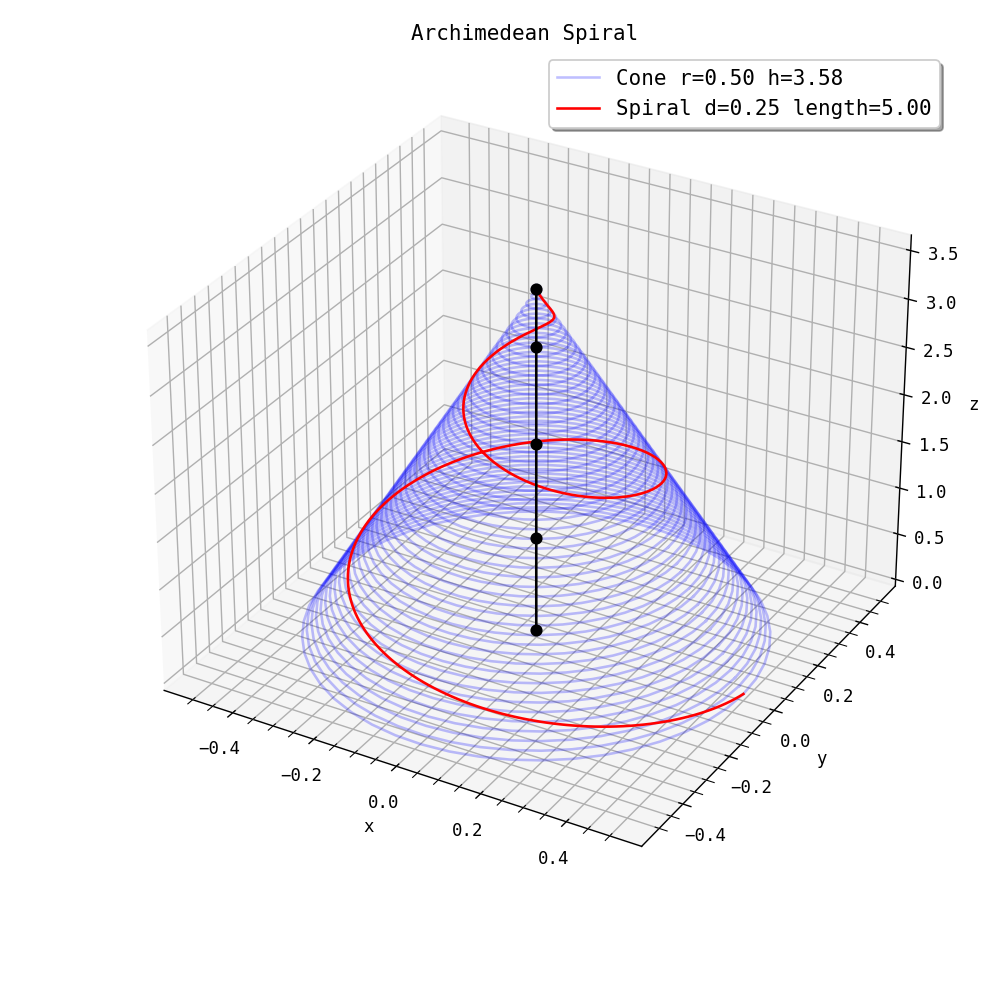

Cone Radius (r) = 0.5000
Cone Height (h) = 3.5841
Sprial Distance (d) = 0.2500


In [14]:
fig, ax = create_standard_figure(
    'Archimedean Spiral',
    'x',
    'y',
    'z',
    projection='3d',
    figsize=(8, 8),                                                  
    axes_rect=(0.1, 0.1, 0.85, 0.85), # rect [left, bottom, width, height]
) 


arc_length = 5   # m
d = 0.25 # m
r = 0.5   # m

h_init = 5   # m

results = find_optimal_h(target_function_h, arc_length, d, r, h_init)

plot_cone_and_sprial(ax, r, results[0], d)

fig.show() 